In [38]:
# print content of folder /content
import os
FOLDER = '/content/drive/MyDrive/course_project'
print(os.listdir(f'{FOLDER}/data'))

['combined_data_filtered_train1.csv_', 'result_processed.json', 'result2_processed.json', 'result2_fixed.json', 'result_processed', 'input_df.csv', 'result_processed2']


In [39]:
import pandas as pd


df = pd.read_csv(f'{FOLDER}/data/input_df.csv')
print(len(df))
df.head()

32694


,text,label
0,", and Environmental Sciences, School of Public...",1
1,R & Bioconductor Manual\n\nmyDF <- as.data.fra...,0
2,Feminist ethics is founded on the views that w...,0
3,The LHC primarily produces a light charged Hig...,1
4,As a high school student struggling to find a ...,1


In [40]:
import os
import json

def load_jsons_from_folder(folder_path):
    """
    Load all JSON files from a folder into a single dictionary.
    Each JSON file is expected to contain a list of objects with 'index' and 'scores' fields.
    All entries from all files will be combined into one dictionary with index as key and scores as value.

    Args:
        folder_path (str): Path to the folder containing JSON files

    Returns:
        dict: Combined dictionary mapping indices to scores
    """
    combined_data = {}

    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"Folder '{folder_path}' does not exist.")
        return combined_data

    count = 400
    # List all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        if count == 0:
            break
        count -= 1

        # Check if it's a file and has a .json extension
        if os.path.isfile(file_path) and filename.lower().endswith('.json'):
            try:
                # Open and load the JSON file
                with open(file_path, 'r') as f:
                    json_data = json.load(f)

                # Process each item in the list
                for item in json_data:
                    if 'index' in item and 'scores' in item:
                        combined_data[item['index']] = item['scores']

                print(f"Loaded: {filename}")
            except json.JSONDecodeError:
                print(f"Error: Could not parse '{filename}' as JSON.")
            except Exception as e:
                print(f"Error loading '{filename}': {str(e)}")

    return combined_data

combined_data = load_jsons_from_folder(f'{FOLDER}/data/result_processed2')
print(len(combined_data))

Loaded: 99_processed.json
Loaded: 199_processed.json
Loaded: 399_processed.json
Loaded: 299_processed.json
Loaded: 499_processed.json
Loaded: 599_processed.json
Loaded: 699_processed.json
Loaded: 799_processed.json
Loaded: 999_processed.json
Loaded: 899_processed.json
Loaded: 1199_processed.json
Loaded: 1099_processed.json
Loaded: 1299_processed.json
Loaded: 1399_processed.json
Loaded: 1499_processed.json
Loaded: 1599_processed.json
Loaded: 1699_processed.json
Loaded: 1799_processed.json
Loaded: 1899_processed.json
Loaded: 1999_processed.json
Loaded: 2099_processed.json
Loaded: 2199_processed.json
Loaded: 2299_processed.json
Loaded: 2399_processed.json
Loaded: 2499_processed.json
Loaded: 2599_processed.json
Loaded: 2699_processed.json
Loaded: 2799_processed.json
Loaded: 2899_processed.json
Loaded: 2999_processed.json
Loaded: 3099_processed.json
Loaded: 3199_processed.json
Loaded: 3299_processed.json
Loaded: 3499_processed.json
Loaded: 3399_processed.json
Loaded: 3599_processed.json
Loa

In [42]:
def match_scores_with_dataframe(combined_data, dataframe, use_index=True, df_id_column=None):
    """
    Match scores from the combined JSON data with rows in a DataFrame.

    Args:
        combined_data (dict): Dictionary mapping indices to scores
        dataframe (pandas.DataFrame): DataFrame to match indices with
        use_index (bool): Whether to use DataFrame index as the ID for matching
        df_id_column (str, optional): Column name in the DataFrame that contains IDs to match with,
                                      only used if use_index is False

    Returns:
        pandas.DataFrame: The original DataFrame with a new 'scores' column
    """
    # Create a copy of the DataFrame to avoid modifying the original
    enhanced_df = dataframe.copy()

    if use_index:
        # Use the DataFrame index as the ID to match with combined_data
        enhanced_df['scores'] = enhanced_df.index.map(lambda idx: combined_data.get(str(idx)) or combined_data.get(idx))
    else:
        # Ensure df_id_column is provided if not using index
        if not df_id_column:
            raise ValueError("df_id_column must be specified when not using index")

        # Check if the specified column exists
        if df_id_column not in enhanced_df.columns:
            raise ValueError(f"Column '{df_id_column}' not found in DataFrame")

        # Add scores to the DataFrame
        enhanced_df['scores'] = enhanced_df[df_id_column].map(combined_data)

    # Report on matching success
    matched_count = enhanced_df['scores'].notna().sum()
    total_count = len(enhanced_df)
    print(f"Matched scores for {matched_count} out of {total_count} rows ({matched_count/total_count*100:.1f}%)")

    # Identify unmatched rows in the DataFrame
    unmatched_indices = enhanced_df[enhanced_df['scores'].isna()].index.tolist()
    if unmatched_indices:
        print(f"Warning: {len(unmatched_indices)} rows in the DataFrame have no matching scores.")
        if len(unmatched_indices) <= 5:
            print(f"Unmatched indices: {unmatched_indices}")
        else:
            print(f"First 5 unmatched indices: {unmatched_indices[:5]}...")

    # Identify unused scores in the combined data
    if use_index:
        used_ids = set(str(idx) for idx in enhanced_df.index)
        # Also check for integer indices
        used_ids.update(set(idx for idx in enhanced_df.index if isinstance(idx, int)))
    else:
        used_ids = set(enhanced_df[df_id_column])

    unused_ids = set(combined_data.keys()) - used_ids
    if unused_ids:
        print(f"Warning: {len(unused_ids)} indices in the scores data have no matching rows in the DataFrame.")
        if len(unused_ids) <= 5:
            print(f"Unused indices: {unused_ids}")
        else:
            print(f"First 5 unused indices: {list(unused_ids)[:5]}...")

    return enhanced_df

# Example usage
# Assuming combined_data has already been loaded from JSON files
# and df is your DataFrame
# enhanced_df = match_scores_with_dataframe(combined_data, df, use_index=True)

# Example usage
# Assuming combined_data has already been loaded from JSON files
# and df is your DataFrame
enhanced_df = match_scores_with_dataframe(combined_data, df, df_id_column='_id')

enhanced_df = enhanced_df.dropna(subset=['scores'])
print(len(enhanced_df))


Matched scores for 7100 out of 32694 rows (21.7%)
First 5 unmatched indices: [7100, 7101, 7102, 7103, 7104]...
7100


In [43]:
enhanced_df.head()

,text,label,scores
0,", and Environmental Sciences, School of Public...",1,"[[13.375, 43776.0, 16.375, 4.875, 127.0, 1.015..."
1,R & Bioconductor Manual\n\nmyDF <- as.data.fra...,0,"[[209.0, 9.8125, 43776.0, 115.5, 5.90625, 732...."
2,Feminist ethics is founded on the views that w...,0,"[[216.0, 2.890625, 856.0, 6.375, 404.0, 1.3906..."
3,The LHC primarily produces a light charged Hig...,1,"[[664.0, 209.0, 126976.0, 33.75, 12.5625, 486...."
4,As a high school student struggling to find a ...,1,"[[7.34375, 430.0, 1.5390625, 2.796875, 1544.0,..."


Using device: cuda
Maximum sequence length: 511


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 0.7197, Train Acc: 51.75%, Val Loss: 0.6920, Val Acc: 52.27%, LR: 0.001000
Epoch [2/100], Train Loss: 0.6916, Train Acc: 53.32%, Val Loss: 0.6912, Val Acc: 52.27%, LR: 0.001000
Epoch [3/100], Train Loss: 0.6871, Train Acc: 53.47%, Val Loss: 0.6875, Val Acc: 52.27%, LR: 0.001000
Epoch [4/100], Train Loss: 0.6770, Train Acc: 55.37%, Val Loss: 0.7075, Val Acc: 52.43%, LR: 0.001000
Epoch [5/100], Train Loss: 0.6654, Train Acc: 58.45%, Val Loss: 0.6609, Val Acc: 52.27%, LR: 0.001000
Epoch [6/100], Train Loss: 0.6545, Train Acc: 56.73%, Val Loss: 0.6800, Val Acc: 52.27%, LR: 0.001000
Epoch [7/100], Train Loss: 0.6629, Train Acc: 58.08%, Val Loss: 0.6529, Val Acc: 61.97%, LR: 0.001000
Epoch [8/100], Train Loss: 0.6330, Train Acc: 62.03%, Val Loss: 0.6288, Val Acc: 63.85%, LR: 0.001000
Epoch [9/100], Train Loss: 0.6209, Train Acc: 62.11%, Val Loss: 0.6232, Val Acc: 63.22%, LR: 0.001000
Epoch [10/100], Train Loss: 0.6076, Train Acc: 64.10%, Val Loss: 0.6123, Val Acc: 

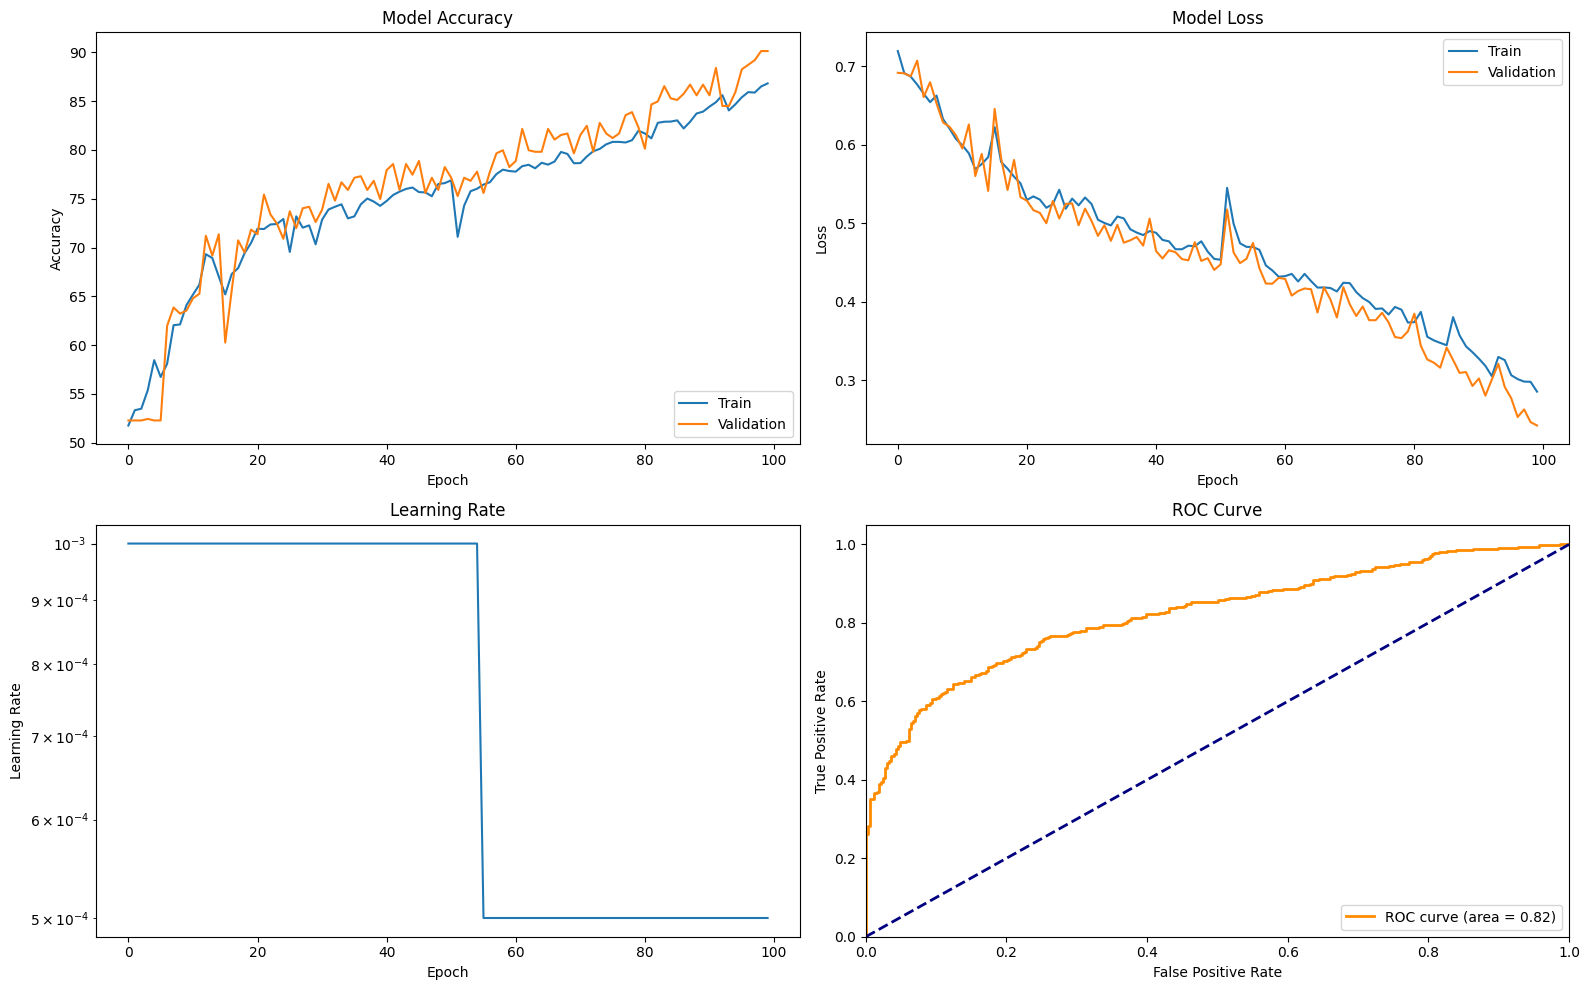

In [56]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt



class BidirectionalRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.1):
        super(BidirectionalRNN, self).__init__()
        self.fc0 = nn.Linear(input_size, input_size)
        self.tanh0 = nn.Tanh()
        self.layer_norm_input = nn.LayerNorm(input_size)

        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        self.dropout1 = nn.Dropout(dropout)
        self.layer_norm1 = nn.LayerNorm(hidden_size*2)

        self.lstm2 = nn.LSTM(
            input_size=hidden_size*2,  # *2 because bidirectional
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm2 = nn.LayerNorm(hidden_size*2)

        ll_size = 100

        self.fc1 = nn.Linear(hidden_size*2, ll_size)  # *2 because bidirectional
        self.relu1 = nn.ReLU()
        self.layer_norm3 = nn.LayerNorm(ll_size)

        self.fc2 = nn.Linear(ll_size, ll_size)
        self.relu2 = nn.ReLU()
        self.layer_norm4 = nn.LayerNorm(ll_size)

        self.fc3 = nn.Linear(ll_size, ll_size)
        self.relu3 = nn.ReLU()
        self.layer_norm5 = nn.LayerNorm(ll_size)

        self.fc4 = nn.Linear(ll_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Initial transformation and normalization
        x = self.tanh0(self.fc0(x))
        # x = self.layer_norm_input(x)

        # First LSTM layer with return_sequences=True
        lstm1_out, _ = self.lstm1(x)
        lstm1_out = self.dropout1(lstm1_out)
        lstm1_out = self.layer_norm1(lstm1_out)

        # Second LSTM layer
        _, (hidden, _) = self.lstm2(lstm1_out)

        # Combine the final forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = self.dropout2(hidden)
        hidden = self.layer_norm2(hidden)

        # Fully connected layers
        fc1_out = self.relu1(self.fc1(hidden))
        fc1_out = self.layer_norm3(fc1_out)

        fc2_out = self.relu2(self.fc2(fc1_out))
        fc2_out = self.layer_norm4(fc2_out)

        fc3_out = self.relu3(self.fc3(fc2_out))
        fc3_out = self.layer_norm5(fc3_out)

        output = self.sigmoid(self.fc4(fc3_out))

        return output



def train_rnn_model(df, scores_column='scores', label_column='label', device=None):
    """
    Train an RNN model using scores and labels from a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing scores arrays and labels
        scores_column (str): Column name that contains the scores arrays
        label_column (str): Column name that contains the labels (0 or 1)
        device (torch.device): Device to train on (CPU or CUDA)

    Returns:
        trained model and training history
    """
    # Set device
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Using device: {device}")

    # Extract scores and labels
    scores_data = df[scores_column].tolist()
    labels = df[label_column].values

    # Check if scores are in the expected format
    if not scores_data or not isinstance(scores_data[0], list) or len(scores_data[0]) != 4:
        raise ValueError("Scores should be a list of 4 arrays for each row")

    # Prepare data in the format required for RNN
    X = []
    seq_lengths = []

    for row_scores in scores_data:
        # Calculate the minimum length of the 4 arrays for this row
        sequence_length = min(len(row_scores[0]), len(row_scores[1]),
                            len(row_scores[2]), len(row_scores[3]))
        seq_lengths.append(sequence_length)

        row_sequence = []
        for i in range(sequence_length):
            # For each position, collect values from all 4 arrays
            timestep_features = [
                row_scores[0][i],
                row_scores[1][i],
                row_scores[2][i],
                row_scores[3][i],
                1/row_scores[0][i],
                1/row_scores[1][i],
                1/row_scores[2][i],
                1/row_scores[3][i]
            ]
            row_sequence.append(timestep_features)
        X.append(row_sequence)

    # Determine the maximum sequence length for padding
    max_seq_length = max(seq_lengths)
    print(f"Maximum sequence length: {max_seq_length}")

    # Pad sequences to the same length
    padded_X = []
    for seq in X:
        # Convert to numpy array
        seq_array = np.array(seq)

        # If sequence is shorter than max_seq_length, pad with zeros
        if len(seq) < max_seq_length:
            padding = np.ones((max_seq_length - len(seq), 8))
            padded_seq = np.vstack((padding, seq_array))
        else:
            # If sequence is longer than max_seq_length, truncate
            padded_seq = seq_array[:max_seq_length]

        padded_X.append(padded_seq)

    X = np.array(padded_X)
    y = np.array(labels)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42, stratify=y
    )

    # Scale the features
    # Reshape to 2D for scaling
    n_samples_train, n_timesteps, n_features = X_train.shape
    X_train_reshaped = X_train.reshape(n_samples_train * n_timesteps, n_features)

    scaler = StandardScaler()
    X_train_reshaped = scaler.fit_transform(X_train_reshaped)

    # Reshape back to 3D
    X_train = X_train_reshaped.reshape(n_samples_train, n_timesteps, n_features)

    # Apply the same scaling to test data
    n_samples_test = X_test.shape[0]
    X_test_reshaped = X_test.reshape(n_samples_test * n_timesteps, n_features)
    X_test_reshaped = scaler.transform(X_test_reshaped)
    X_test = X_test_reshaped.reshape(n_samples_test, n_timesteps, n_features)

    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train.reshape(-1, 1)).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.FloatTensor(y_test.reshape(-1, 1)).to(device)

    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=300,  # Same as in the TensorFlow code
        shuffle=True
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=300,
        shuffle=True
    )

    # Initialize the model
    model = BidirectionalRNN(input_size=n_features).to(device)

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Initialize learning rate scheduler
    # Using ReduceLROnPlateau to reduce learning rate when validation loss plateaus
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',          # Reduce LR when monitored quantity stops decreasing
        factor=0.5,          # Multiply LR by this factor
        patience=5,          # Number of epochs with no improvement after which LR will be reduced
        verbose=True,        # Print message when LR is reduced
        min_lr=1e-6          # Lower bound on the learning rate
    )

    # Alternatively, you can use other schedulers:
    # Step LR scheduler - reduces LR by a factor every step_size epochs
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Cosine Annealing scheduler - reduces LR following a cosine curve
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    # Early stopping parameters
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'learning_rates': []  # Track learning rates
    }

    # Number of epochs
    num_epochs = 100

    # Create a validation dataset
    val_size = int(0.1 * len(train_dataset))
    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset,
        [len(train_dataset) - val_size, val_size]
    )

    val_loader = DataLoader(
        dataset=val_subset,
        batch_size=64,
        shuffle=False
    )

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

        # Calculate average training loss and accuracy
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()

                # Calculate accuracy
                predicted = (outputs > 0.5).float()
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

        # Calculate average validation loss and accuracy
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        # Update learning rate scheduler
        scheduler.step(avg_val_loss)

        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)

        # Print epoch statistics
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, '
              f'LR: {current_lr:.6f}')

        # Save history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(val_accuracy)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Evaluate the model
    model.eval()
    y_pred_proba = []
    y_true = []

    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()

            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            # Store predictions and targets for metrics
            y_pred_proba.extend(outputs.cpu().numpy())
            y_true.extend(targets.cpu().numpy())

    # Convert lists to numpy arrays
    y_pred_proba = np.array(y_pred_proba).flatten()
    y_true = np.array(y_true).flatten()

    # Calculate prediction labels
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Print evaluation metrics
    accuracy = 100 * correct / total
    print(f"Test accuracy: {accuracy:.2f}%")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    # Calculate ROC curve data
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.close()

    return model, history, y_true, y_pred_proba

# Modified function to plot training history including learning rate
def plot_training_history(history, y_test, y_pred_proba):
    plt.figure(figsize=(16, 10))

    # Model Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history['train_acc'])
    plt.plot(history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Model Loss
    plt.subplot(2, 2, 2)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Learning Rate
    plt.subplot(2, 2, 3)
    plt.plot(history['learning_rates'])
    plt.title('Learning Rate')
    plt.ylabel('Learning Rate')
    plt.xlabel('Epoch')
    plt.yscale('log')  # Log scale for better visualization

    # ROC curve
    plt.subplot(2, 2, 4)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.savefig('training_history_with_lr.png')
    plt.show()

# Assuming enhanced_df is already prepared
model, history, y_test, y_pred_proba = train_rnn_model(enhanced_df)

# Save the model
# save_model(model, 'rnn_classifier_model.pth')

# Plot training history
plot_training_history(history, y_test, y_pred_proba)